<a href="https://colab.research.google.com/github/DhruvK278/Invoice-OCR/blob/main/invoice_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install opencv-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
# Import libraries
import cv2
import pytesseract
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


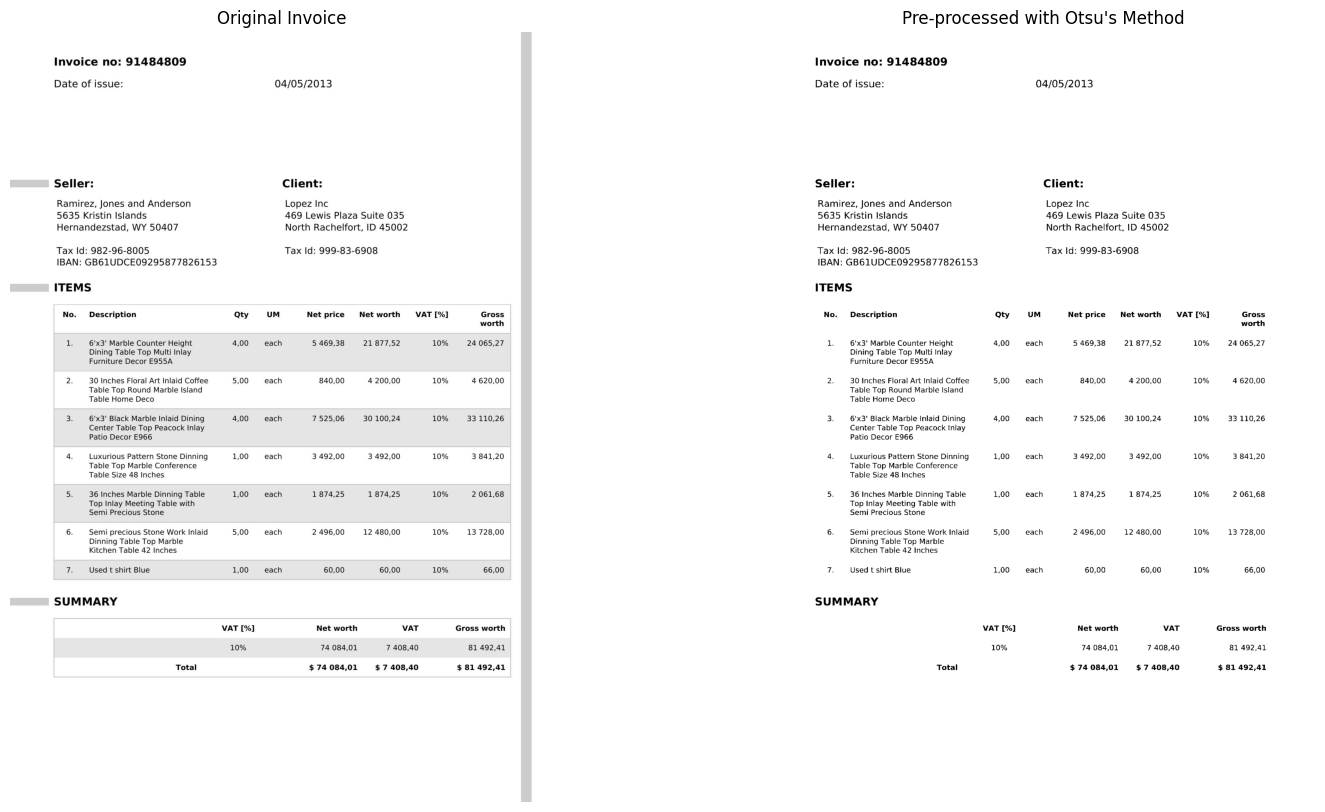

In [3]:

file_path = 'invoice.png'

# Load the image using OpenCV
try:
    original_image = cv2.imread(file_path)
    # Convert to grayscale
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's Binarization
    # This automatically finds the best threshold value.
    _, processed_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

except Exception as e:
    print(f"Error: Could not load image from '{file_path}'.")
    print(e)
    processed_image = None

if processed_image is not None:
    plt.figure(figsize=(18, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Invoice')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_image, cmap='gray')
    plt.title('Pre-processed with Otsu\'s Method')
    plt.axis('off')

    plt.show()

In [10]:
# ===================================================================
# CELL 5: OCR AND DATA PARSING (FINAL GROUPING LOGIC)
# ===================================================================
if processed_image is not None:
    print("\nStep 5: Performing OCR and Parsing Data with final grouping logic...")

    data = pytesseract.image_to_data(processed_image, output_type=Output.DICT, config='--psm 6')

    # Reconstruct lines from Tesseract's word data
    lines = {}
    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 20:
            line_num = data['line_num'][i]
            if line_num not in lines:
                lines[line_num] = []
            lines[line_num].append(data['text'][i])
    reconstructed_lines = [" ".join(words) for words in lines.values()]

    # --- Initialize data holders ---
    parsed_data = {}
    line_items = []

    # --- Define Regex Patterns ---
    inv_num_pattern = re.compile(r'invoice\s*no[:\s]*(\S+)', re.IGNORECASE)
    date_pattern = re.compile(r'date\s*of\s*issue[:\s]*(\S+)', re.IGNORECASE)
    total_pattern = re.compile(r'total\s+\$?\s*([\d\s,]+\.\d{2}|\$?\s*[\d\s,]+\.\d{2})', re.IGNORECASE)

    # THIS IS THE FINAL, CORRECTED PATTERN.
    # It now accepts a comma OR a dot after the line number digit -> ^\d[\.,]
    line_item_pattern = re.compile(r'^\d[\.,]\s+(.+?)\s+(\d+,\d{2})\s+each\s+([\d\s]+\,\d{2})\s+([\d\s]+\,\d{2})\s+\d+%\s+([\d\s]+\,\d{2})')

    # --- New Grouping Parser Logic ---
    i = 0
    while i < len(reconstructed_lines):
        line = reconstructed_lines[i]

        # Parse header info just once
        if not parsed_data.get('InvoiceNumber') and inv_num_pattern.search(line):
            parsed_data['InvoiceNumber'] = inv_num_pattern.search(line).group(1)
        if not parsed_data.get('InvoiceDate') and date_pattern.search(line):
            parsed_data['InvoiceDate'] = date_pattern.search(line).group(1)
        if total_pattern.search(line):
            parsed_data['TotalAmount'] = total_pattern.search(line).group(1)

        # Try to match a primary line item
        match = line_item_pattern.search(line)
        if match:
            # We found a primary line! Parse its data.
            description = match.group(1).strip()
            quantity = float(match.group(2).replace(',', '.'))
            net_price = float(match.group(3).replace(' ', '').replace(',', '.'))
            net_worth = float(match.group(4).replace(' ', '').replace(',', '.'))
            gross_worth = float(match.group(5).replace(' ', '').replace(',', '.'))

            # Now, look ahead to the next lines to find additional description text
            j = i + 1
            while j < len(reconstructed_lines):
                next_line = reconstructed_lines[j]
                # If the next line starts with a digit, it's a new item, so we stop.
                if re.match(r'^\d[\.,]', next_line):
                    break
                # Otherwise, it's part of the current item's description.
                description += " " + next_line.strip()
                j += 1

            # Create the final item dictionary
            item = {
                'Description': description,
                'Quantity': quantity,
                'Net Price': net_price,
                'Net Worth': net_worth,
                'Gross Worth': gross_worth
            }
            line_items.append(item)

            # Skip the main loop ahead to avoid re-processing the description lines
            i = j - 1

        i += 1

    print("✅ Parsing Complete with final logic!")


Step 5: Performing OCR and Parsing Data with final grouping logic...
✅ Parsing Complete with final logic!


In [11]:
if 'parsed_data' in locals():
    print("\n\n---RESULT ---")
    print("\n---------- PARSED INVOICE SUMMARY ----------")
    for key, value in parsed_data.items():
        print(f"{key}: {value}")
    print("------------------------------------------\n")

    if line_items:
        print("----------- DETECTED LINE ITEMS -----------")
        df = pd.DataFrame(line_items)
        display(df)
    else:
        print("--- ⚠️ No line items were detected ---")
        print("This may be due to a new invoice format. The regex pattern in Cell 5 may need adjustment.")




---RESULT ---

---------- PARSED INVOICE SUMMARY ----------
InvoiceNumber: 91484809
InvoiceDate: 04/05/2013
------------------------------------------

----------- DETECTED LINE ITEMS -----------


,Description,Quantity,Net Price,Net Worth,Gross Worth
0,6'x3' Marble Counter Height Dining Table Top M...,4.0,5469.38,21877.52,24065.27
1,30 Inches Floral Art Inlaid Coffee Table Top R...,5.0,840.00,4200.00,4620.00
2,6'x3' Black Marble Inlaid Dining Center Table ...,4.0,7525.06,30100.24,33110.26
3,Luxurious Pattern Stone Dinning Table Top Marb...,1.0,3492.00,3492.00,3841.20
4,36 Inches Marble Dinning Table Top Inlay Meeti...,1.0,1874.25,1874.25,2061.68
5,Semi precious Stone Work Inlaid Dinning Table ...,5.0,2496.00,12480.00,13728.00
6,Used t shirt Biue SUMMARY VAT [%] Net worth VA...,1.0,60.00,60.00,66.00


In [ ]:
if 'df' in locals() and not df.empty:
    # Save the line items DataFrame to CSV
    df.to_csv('invoice_items.csv', index=False)

    # Save the summary data
    summary_df = pd.DataFrame([parsed_data])
    summary_df.to_csv('invoice_summary.csv', index=False)

    print("✅ Successfully saved data to invoice_summary.csv and invoice_items.csv")
